# Numpyro version

This is about 100x faster! and the code is nicer! joy oh joy!

# The Bayesian Sampler model is roughly:

$$P_{BS}(A) \sim Beta(\beta + S(A), \beta+F(A))$$

Where $S(A)$ and $F(A)$ are the number of success and failures sampled.

We can rewrite that:

$$P_{BS}(A) \sim Beta(\beta + \pi(A)N, \beta+(1-\pi(A))N)$$


Where $\pi(A)$ is the proportion of successes in the mental simulation with $N$ samples and is a function of the true underlying model probability, $p(A)$. It is distributed:

$$\pi(A) \sim Beta(p(A)*N, (1-p(A))*N)$$

To which we assign a uniform prior (or the multidimensional dirichlet equivalent):

$$p(A) \sim Beta(1,1)$$

This notebook will be dedicated to estimating parameters within some __simulated data__.

In [9]:
# %config IPCompleter.use_jedi = False
import numpyro
numpyro.enable_x64()
numpyro.set_platform('gpu') # uncomment to use cpu
# numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from jax.random import PRNGKey
from numpyro.infer import MCMC, NUTS, Predictive

# import pyro.infer
# import pyro.optim
# import pyro.distributions as dist
# from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
import functools

import siuba as s
from siuba import _


from dfply import mutate, X
# %run -i 'model_helpers.py'
# %run -i 'models.py'

from lib.helpers import *
from lib.models import *
from lib.simdata import make_sim_data_trials

## Simulate data

## create and fit model

Easiest to focus on fitting for a single participant

In [10]:
n_participants, n_blocks, n_conditions = 20, 6, 4 # 20, 3, 2 --> led to accurate-ish paramter recover for N, beta (not so great for N')

np.random.seed(323256) ## old school but works here

params = {
    "N_base": {k: np.exp(1 + np.random.normal(1, .5)) for k in range(0,n_participants)},
    "N_delta": {k: np.exp(np.random.normal(1, .5)) for k in range(0,n_participants)},
    "beta": {k: np.random.beta(5,1) for k in range(0, n_participants)},
}

sim_data = make_sim_data_trials(n_participants, n_blocks, n_conditions, params)
sim_data["estimate"] = sim_data.estimate_bs

# df = (sim_data >>
#       s.mutate(estimate = np.round(_.estimate*20.))
#      )

## adding in rounding policies

df = (
    sim_data >>
    s.mutate(rnd_policy = np.random.choice([0,1,2], size = len(sim_data), p = [.1,.4,.5])) >>
    s.mutate(estimate = s.if_else(
        _.rnd_policy==0, np.round(np.random.beta(1,1, len(sim_data))*20.),
        s.if_else(_.rnd_policy==1, np.round(_.estimate*20.), np.round(_.estimate*10.)*2.)
    ))
)

df.estimate = df.estimate.astype("int64")

X_data, y_data = make_model_data(df) # see data_helpers.py
print(len(y_data), "observations")

9600 observations


In [15]:

def load_data_exp2_trials():
    df = load_raw_data(2)
    
    df["condition"] = np.select(
    [
        df.querydetail.str.contains("windy|cloudy"), 
        df.querydetail.str.contains("cold|rainy"),
        df.querydetail.str.contains("warm|snowy")

    ], 
    [
        0,
        1,
        2
    ], 
    default=0 )
    
    original_ids = list(np.unique(df.ID))
    fix_id_dict = {original_ids[i]:i for i in range(0, len(original_ids))}
    
    df = df.assign(ID = df.ID.apply(lambda x: fix_id_dict[x]))

    return df

df = load_data_exp2_trials() # see data_helpers.py
df = df[df["condition"]!=2] # filter out "warm/snowy" as per paper
# df = df.sort_values(by=["ID","block","condition"]) # don't think I need to sort?

df = (df >> 
      s.mutate(block = _.block-1) >> 
#       s.filter(_.block==0, _.ID < 20) >>
      # s.group_by(_.ID, _.condition, _.querytype, _.querydetail) >> 
      # s.summarize(estimate = _.estimate.mean()) >>
      s.mutate(estimate =  np.round(_.estimate*20))
     )
df.estimate = df.estimate.astype("int64")

X_data, y_data = make_model_data(df) # see data_helpers.py
print(len(y_data), "observations")

10080 observations


In [21]:
df

,ID,block,trial,query,querydetail,querytype,estimate,starttime,endtime,RT,condition
0,33,0,1,If the weather in England is not rainy on a ra...,cold given not rainy,AgnotB,12,169889.823203,169932.484902,42.661700,1
1,33,0,2,What is the probability that the weather will ...,not rainy,notB,8,169932.589839,169949.222069,16.632230,1
2,33,0,3,If the weather in England is cold on a random ...,rainy given cold,BgA,14,169949.339867,169963.399896,14.060029,1
3,33,0,4,What is the probability that the weather will ...,cold or not rainy,AornotB,6,169963.539867,169986.863272,23.323405,1
6,33,0,7,If the weather in England is not windy on a ra...,cloudy given not windy,BgnotA,16,170033.306592,170040.885977,7.579385,0
...,...,...,...,...,...,...,...,...,...,...,...
15108,38,2,49,If the weather in England is cold on a random ...,rainy given cold,BgA,18,174808.605599,174812.260318,3.654719,1
15109,38,2,50,If the weather in England is windy on a random...,not cloudy given windy,notBgA,14,174812.422244,174815.999388,3.577144,0
15110,38,2,51,What is the probability that the weather will ...,cloudy or not windy,notAorB,14,174816.138868,174819.109773,2.970904,0
15111,38,2,52,If the weather in England is rainy on a random...,not cold given rainy,notAgB,12,174819.272194,174824.684405,5.412211,1


<AxesSubplot:xlabel='estimate'>

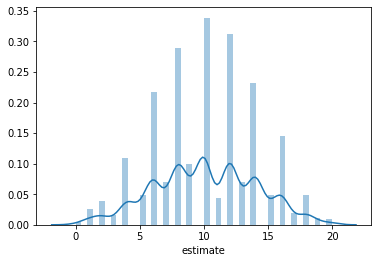

In [17]:
## sanity check
sns.distplot(df.estimate)

In [117]:
import tensorflow_probability.substrates.jax as tfp

def prob_judge_BS(theta, X_num, X_denom, N, beta):

    pi = calc_prob(theta, X_num, X_denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    return p_bs

def prob_judge_BS_d(theta, X_num, X_denom, d):

    pi = calc_prob(theta, X_num, X_denom)
    return calc_ptn_prob(pi, d)


## rounding stuff
from jax import vmap

def spread_vec(x, step_size): # this works without static arguments
    base_steps = x.shape[0]
    x_split = jnp.split(x, base_steps)
    pad = jnp.zeros(step_size-1)
    probs = jnp.stack([jnp.concatenate((i,pad)) for i in x_split]).flatten()
    probs = probs[0:21]
    return probs/jnp.sum(probs)


def f(mu, k, responses):
    
    a = mu*k
    b = (1.-mu)*k
    
    n_resps = (responses.shape[0]-1)
    step = int(20/n_resps)
    rnd_unit_scaled = 1/n_resps
    
    lower = jnp.clip((responses/n_resps) - rnd_unit_scaled/2., 1e-8, 1-1e-8)
    upper = jnp.clip((responses/n_resps) + rnd_unit_scaled/2., 1e-8, 1-1e-8)
    
    prob_resps = tfp.math.betainc(a, b, upper) - tfp.math.betainc(a, b, lower)
    prob_resps = (spread_vec(prob_resps, step) + 1e-30)
    prob_resps = (prob_resps)/jnp.sum(prob_resps)
    # prob_resps = (prob_resps + 1e-30) / jnp.sum(prob_resps) # add err to prevent divergences
    
    return(prob_resps)


lbeta_cat_probs = vmap(f, (0, 0, None)) # change to map for k

responses_10 = jnp.linspace(0, 10, num=11)
responses_5 = jnp.linspace(0, 20, num=21)

def ptn_simplecond_mlm_trial_level_disc(data, y=None):
    
    # parameterized in terms of d and d' for comparison of model fit

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
#     k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
    rnd_policy = numpyro.sample("rnd_policy", dist.Dirichlet(jnp.ones(3)))
    
    d_base_pop = numpyro.sample("d_base_pop", dist.Normal(-1.0, 1.0))
    d_delta_pop = numpyro.sample("d_delta_pop", dist.Normal(0, .5)) # bias toward lower values for non conj/disj trials
    d_base_sd = numpyro.sample("d_base_sd", dist.LogNormal(-1., 1.)) # was halfcauchy(1)
    d_delta_sd = numpyro.sample("d_delta_sd", dist.LogNormal(-1., 1.)) # approx uniform altogether we hope

    # subject-level parameters/priors 
    with numpyro.plate("subj", n_Ps):
        d_bases = numpyro.sample("d_base_r", dist.Normal(0, 1))
        d_deltas = numpyro.sample("d_delta_r", dist.Normal(0, 1))
        ks = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    d_lin = (d_base_pop + 
             d_bases[subj]*d_base_sd + 
             jnp.exp(d_delta_pop + d_delta_sd*d_deltas[subj])*conjdisj
            )  # exp() constrains d_delta to be positive
    d = sigmoid(d_lin)/2.0 # require this be in [0, 1/3]
    
    numpyro.deterministic("d_subj", sigmoid(d_base_pop + d_bases*d_base_sd)/3.)
    numpyro.deterministic("d_prime_subj", 
                          sigmoid(d_base_pop + 
                                  d_bases*d_base_sd + 
                                  jnp.exp(d_delta_pop + d_deltas*d_delta_sd)
                                 )/2.
                         )
    
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
        
    p_bs = prob_judge_BS_d(theta, X_num, X_denom, d)
    k = ks[subj]
    
    resp_probs = (
        1./21.*rnd_policy[0] +
        lbeta_cat_probs(p_bs, k, responses_5)*rnd_policy[1] + 
        lbeta_cat_probs(p_bs, k, responses_10)*rnd_policy[2]
    )

    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Categorical(probs=resp_probs), obs=y) # rounded
        return(yhat)
    
    
## -- bayesian sampler



def prob_judge_BS(theta, X_num, X_denom, N, beta):

    pi = calc_prob(theta, X_num, X_denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    return p_bs

def prob_judge_BS_d(theta, X_num, X_denom, d):

    pi = calc_prob(theta, X_num, X_denom)
    return calc_ptn_prob(pi, d)


## rounding stuff
from jax import vmap

def spread_vec(x, step_size): # this works without static arguments
    base_steps = x.shape[0]
    x_split = jnp.split(x, base_steps)
    pad = jnp.zeros(step_size-1)
    probs = jnp.stack([jnp.concatenate((i,pad)) for i in x_split]).flatten()
    probs = probs[0:21]
    return probs/jnp.sum(probs)


def bs_dist(p, beta, N):
    return (p * N) / (N + 2 * beta) + beta / (N + 2 * beta)


def bs_dist_inv(x, beta, N):
    return (x - beta / (N + 2. * beta)) * (N + 2. * beta) / N


def bs_dist_cdf(N, beta, a, b, x):
    # where x is untransformed probability
    trans_x = bs_dist_inv(x, beta, N)

    res = jnp.where(
        jnp.logical_or( trans_x <= 0., trans_x >= 1.), 
        jnp.clip(trans_x, 0., 1.), 
        tfp.math.betainc(a, b, jnp.clip(trans_x, 1e-8, 1-1e-8))
    )

    return res


def f_bs(mu, N, beta, responses):
    
    a = mu*N
    b = (1.-mu)*N
    
    n_resps = (responses.shape[0]-1)
    step = int(20/n_resps)
    rnd_unit_scaled = 1/n_resps
    
    lower = jnp.clip((responses/n_resps) - rnd_unit_scaled/2., 1e-8, 1-1e-8)
    upper = jnp.clip((responses/n_resps) + rnd_unit_scaled/2., 1e-8, 1-1e-8)
    
    prob_resps = bs_dist_cdf(N, beta, a, b, upper) - bs_dist_cdf(N, beta, a, b, lower)
    prob_resps = (spread_vec(prob_resps, step) + 1e-30)
    prob_resps = (prob_resps)/jnp.sum(prob_resps)
    
    return(prob_resps)


bs_cat_probs = vmap(f_bs, (0, 0, 0, None))

responses_10 = jnp.linspace(0, 10, num=11)
responses_5 = jnp.linspace(0, 20, num=21)

# def bs_complex_mlm_trial_level(data, y=None):

#     # Data processing
#     trial, subj, cond = data["trial"], data["subj"], data["cond"]
#     n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 

#     # setup "design matrix" (of sorts)
#     X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
#     conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

#     # population level parameters/priors
#     # k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
#     beta_pop = numpyro.sample("beta_pop", dist.Normal(-2.75, .9)) # skewed after sigmoid
#     beta_sd = numpyro.sample("beta_sd", dist.HalfCauchy(1))

#     N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(0,2)) # mildly informative
#     N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(0,2)) 
#     N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfCauchy(2))
#     N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfCauchy(2))
    
#     rnd_policy = numpyro.sample("rnd_policy", dist.Dirichlet(jnp.ones(3)))

#     # subject-level parameters/priors <--- maybe change to non-centered parameterization for all these
#     with numpyro.plate("subj", n_Ps):
#         betas = numpyro.sample("beta_r", dist.Normal(0, 1))*beta_sd 
#         N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, 1))*N_delta_sd
#         N_primes = numpyro.sample("N_prime_r", dist.Normal(0, 1))*N_prime_sd

#     # subject/query-level parameters/priors
#     with numpyro.plate("cond", n_Ps*n_conds):
#         thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

#     beta = sigmoid(beta_pop + betas[subj])*10 # constrains beta to [0,10]
#     # beta = jnp.exp(beta_pop + betas[subj])
#     numpyro.deterministic("beta_subj", jnp.exp(beta_pop + betas))

#     # exp() needed to constrain N and N_delta positive
#     N = 1 + jnp.exp(N_prime_pop + N_primes[subj]) + jnp.exp(N_delta_pop + N_deltas[subj]) * not_conjdisj # they also required N be at least 1

#     numpyro.deterministic("N_subj", 1 + jnp.exp(N_prime_pop + N_primes))
#     numpyro.deterministic("N_prime_subj", 1 + jnp.exp(N_prime_pop + N_primes) + jnp.exp(N_delta_pop + N_deltas))

#     theta_ind = ((subj*n_conds)+cond)
#     theta = thetas[theta_ind,:]
    
#     pi = calc_prob(theta, X_num, X_denom)
    
# #     numpyro.factor("betacheck", jnp.sum(jnp.where(beta > N, -1e16, 0)))

#     # Likelihood
#     with numpyro.plate("data", len(trial)):
        
#         resp_probs = (
#         1./21.*rnd_policy[0] +
#         bs_cat_probs(pi, N, beta, responses_5)*rnd_policy[1] + 
#         bs_cat_probs(pi, N, beta, responses_10)*rnd_policy[2]
#         )
        
#         yhat = numpyro.sample("yhat", dist.Categorical(probs=resp_probs), obs=y) # rounded


#     return yhat

from jax.nn import softplus

def bs_complex_mlm_trial_level(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 

    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    # k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
    beta_pop = numpyro.sample("beta_pop", dist.Normal(-2.75, .9)) # skewed after sigmoid
    beta_sd = numpyro.sample("beta_sd", dist.HalfCauchy(1))

    N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(0,2)) # mildly informative
    N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(0,2)) 
    N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfCauchy(2))
    N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfCauchy(2))
    
    rnd_policy = numpyro.sample("rnd_policy", dist.Dirichlet(jnp.ones(3)))

    # subject-level parameters/priors <--- non-centered parameterization for all these
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta_r", dist.Normal(0, 1))*beta_sd 
        N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, 1))*N_delta_sd
        N_primes = numpyro.sample("N_prime_r", dist.Normal(0, 1))*N_prime_sd

    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    beta = sigmoid(beta_pop + betas[subj])*10 # constrains beta to [0,10]
    
    # beta = softplus(beta_pop + betas[subj])
    
    numpyro.deterministic("beta_subj", softplus(beta_pop + betas))

    # exp() needed to constrain N and N_delta positive
    N = 1 + softplus(N_prime_pop + N_primes[subj]) + softplus(N_delta_pop + N_deltas[subj]) * not_conjdisj # they also required N be at least 1

    numpyro.deterministic("N_subj", 1 + softplus(N_prime_pop + N_primes))
    numpyro.deterministic("N_prime_subj", 1 + softplus(N_prime_pop + N_primes) + softplus(N_delta_pop + N_deltas))

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
    
    pi = calc_prob(theta, X_num, X_denom)

    # Likelihood
    with numpyro.plate("data", len(trial)):
        
        resp_probs = (
        1./21.*rnd_policy[0] +
        bs_cat_probs(pi, N, beta, responses_5)*rnd_policy[1] + 
        bs_cat_probs(pi, N, beta, responses_10)*rnd_policy[2]
        )
        
        yhat = numpyro.sample("yhat", dist.Categorical(probs=resp_probs), obs=y) # rounded


    return yhat


In [120]:
from numpyro.infer.svi import SVI
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoLaplaceApproximation, AutoDAIS, AutoBNAFNormal, AutoIAFNormal, AutoMultivariateNormal
from numpyro.optim import Adam, ClippedAdam
from numpyro.infer import Trace_ELBO, TraceGraph_ELBO, TraceMeanField_ELBO, init_to_median

guide = AutoMultivariateNormal(bs_complex_mlm_trial_level) #, init_loc_fn=init_to_median()
optimizer = ClippedAdam(1e-3, clip_norm=1.)
loss = TraceGraph_ELBO(num_particles=1)
svi = SVI(bs_complex_mlm_trial_level, guide, optimizer, loss)


# pickle.dump(az_data, open("local/az-ptn_simplecond_mlm_trial_level_disc-sim50-2ksamples.p", "wb"))
# pickle.dump({"params":svi_result.params, "losses":svi_result.losses}, open("local/ptn_simplecond_mlm_trial_level_disc-sim50-svi.p", "wb"))


In [121]:
svi_result = svi.run(random.PRNGKey(1), 5_000, X_data, y_data)

100%|██████████| 5000/5000 [19:33<00:00,  4.26it/s, init loss: 32475.6985, avg. loss [4751-5000]: 26891.1908]


In [68]:
import pickle
pickle.dump({"params":svi_result.params, "losses":svi_result.losses, "guide":guide}, open("local/bs_complex_mlm_trial_level-exp2-svi.p", "wb"))

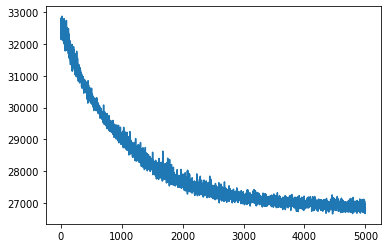

In [122]:
from matplotlib import pyplot as plt
plt.plot(svi_result.losses)

In [123]:
def arviz_from_svi(model, guide, params, *args, obs_data=None, num_samples = 1_000):
    
    posterior_samples = guide.sample_posterior(random.PRNGKey(1), params=params, sample_shape=(num_samples,))
    samples_posterior_predictive = Predictive(model=model, posterior_samples=posterior_samples)(random.PRNGKey(1), *args)
    samples_prior_predictive = Predictive(model=model, params=None, num_samples=num_samples)(random.PRNGKey(2), *args)

    return az.from_dict(
        {k: np.expand_dims(v, 0) for k, v in posterior_samples.items()},
        prior = {k: np.expand_dims(v, 0) for k, v in samples_prior_predictive.items()},
        posterior_predictive = {k: np.expand_dims(v, 0) for k, v in samples_posterior_predictive.items()},
        observed_data = {"yhat": obs_data}
    )

az_data = arviz_from_svi(bs_complex_mlm_trial_level, guide, svi_result.params, X_data, obs_data = y_data, num_samples=1_000)


In [61]:
# import pickle
# result = pickle.load(open("local/bs_complex_mlm_trial_level-sim50-svi.p", "rb"))
# az_data = arviz_from_svi(bs_complex_mlm_trial_level, result["guide"], result["params"], X_data, obs_data = y_data, num_samples=1_000)

# import matplotlib.pyplot as plt
# plt.plot(result["losses"])

In [158]:
# az_data = pickle.load(open("local/az-ptn_simplecond_mlm_trial_level_disc-sim50-2ksamples.p", "rb"))

<AxesSubplot:xlabel='yhat / yhat'>

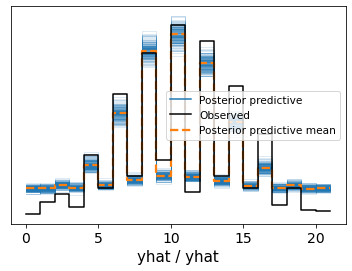

In [124]:
az.plot_ppc(az_data, num_pp_samples=200)

In [18]:
# mcmc_bs_mlm.print_summary()
# az_data_bs = make_arviz_data(mcmc_bs_mlm, bayesian_sampler_complex_mlm_d, X_data)

In [160]:
import scipy
## pull out samples for each individual and match back up with data
## see if we're recovering the original parameters ...

def extract_samples(z, var_name, prior=False):
    if prior:
        x1 = pd.DataFrame(np.array(z.prior[var_name]))
    else:
        x1 = pd.DataFrame(np.array(z.posterior[var_name]))
    
    x1 = x1.reset_index() >> s.gather("draw", "value", -_.index) >> s.mutate(var = var_name)
    
    return(x1)

def dist_to_df(az_data, var_list, prior=False):
    # note variables must have same raw dimensions
    z = az_data.stack(sample=['chain','draw'])
    if len(var_list) > 0:
        df_list = [extract_samples(z, v, prior) for v in var_list]
        df = pd.concat(df_list)
    
        df = df >> s.spread("var", "value")
    
    return(df)


In [161]:
def posterior_to_df_mlm(az_data, fixed_list, random_list):
    fixeds = dist_to_df(az_data, fixed_list) >> s.mutate(draw = _.index) >> s.select(-_.index)
    randoms = dist_to_df(az_data, random_list)

    df_posterior = pd.merge(fixeds, randoms, on="draw") >> s.rename(ID = _.index)
    
    return(df_posterior)


def prior_to_df_mlm(az_data, fixed_list, random_list):
    fixeds = dist_to_df(az_data, fixed_list, prior=True) >> s.mutate(draw = _.index) >> s.select(-_.index)
    randoms = dist_to_df(az_data, random_list, prior=True)

    df_prior = pd.merge(fixeds, randoms, on="draw") >> s.rename(ID = _.index)
    
    return(df_prior)
    
    
# df_posterior = posterior_to_df_mlm(
#     az_data, 
#     ["d_base_pop", "d_delta_pop", "d_base_sd", "d_delta_sd"],
#     ["d_base_r", "d_delta_r", "d_subj", "d_prime_subj", "k"]
# )

df_posterior = posterior_to_df_mlm(
    az_data, 
    ["N_prime_pop", "N_delta_pop", "N_prime_sd", "N_delta_sd", "beta_pop", "beta_sd"],
    ["N_prime_r", "N_delta_r", "beta_r"]
)


In [162]:
# df_posterior >> s.filter(_.ID==0)
df_posterior

,draw,N_delta_pop,N_delta_sd,N_prime_pop,N_prime_sd,beta_pop,beta_sd,ID,N_delta_r,N_prime_r,beta_r
0,0,-0.286586,2.103229,2.296015,0.209159,-1.056420,1.074112,0,-0.537295,-1.389001,-0.798740
1,0,-0.286586,2.103229,2.296015,0.209159,-1.056420,1.074112,1,1.075847,-0.602159,-0.282786
2,0,-0.286586,2.103229,2.296015,0.209159,-1.056420,1.074112,2,0.735059,2.071519,-1.154667
3,0,-0.286586,2.103229,2.296015,0.209159,-1.056420,1.074112,3,0.513609,-0.055771,-1.529790
4,0,-0.286586,2.103229,2.296015,0.209159,-1.056420,1.074112,4,0.963759,0.295342,-0.864502
...,...,...,...,...,...,...,...,...,...,...,...
19995,999,-0.411796,1.967455,2.357678,0.181207,-1.058372,0.996485,15,0.646229,-1.523582,-0.589044
19996,999,-0.411796,1.967455,2.357678,0.181207,-1.058372,0.996485,16,-0.760049,-0.200763,-1.496449
19997,999,-0.411796,1.967455,2.357678,0.181207,-1.058372,0.996485,17,-0.269294,-0.530157,-1.157053
19998,999,-0.411796,1.967455,2.357678,0.181207,-1.058372,0.996485,18,1.321766,-0.501251,-1.558801


In [163]:
az_data.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.10727352, 0.40920568, 0.4835208 ]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

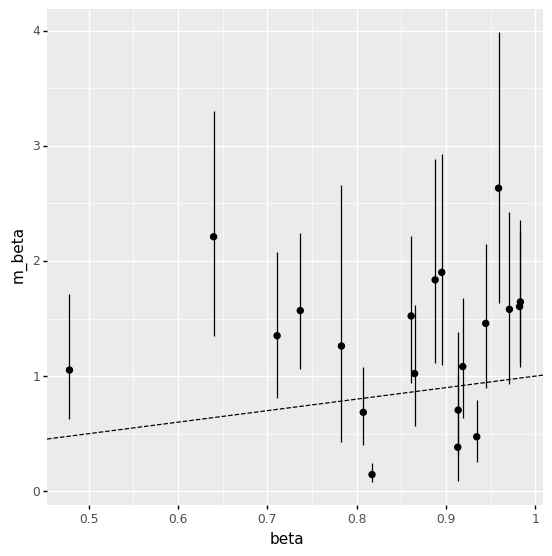

<ggplot: (2980126785000)>

In [87]:
### bayesian sampler

from plotnine import * 

from scipy.special import expit

x = (
    df_posterior >>
    s.mutate(N_prime = 1 + np.exp(_.N_prime_pop + _.N_prime_r * _.N_prime_sd), 
             N_base = _.N_prime + np.exp(_.N_delta_pop + _.N_delta_r *  _.N_delta_sd),
             beta = expit(_.beta_pop + _.beta_r * _.beta_sd)*10
         ) >> 
    s.group_by("ID") >>
    s.summarize(
        m_prime = _.N_prime.mean(),
        ll_prime = _.N_prime.quantile(.025),
        ul_prime = _.N_prime.quantile(.975),
        m_base =_.N_base.mean(),
        ll_base = _.N_base.quantile(.025),
        ul_base = _.N_base.quantile(.975),
        
        m_beta =_.beta.mean(),
        ll_beta = _.beta.quantile(.025),
        ul_beta = _.beta.quantile(.975)
    )
)


subj_params = (
    pd.DataFrame(params).reset_index() >> 
    s.rename(ID = _.index) >>
    s.mutate(
        true_N_base = _.N_base + _.N_delta,
        true_N_prime = _.N_base
    )
)


# (
#     pd.merge(x, subj_params, on = "ID") >> 
# #     s.mutate(ok = s.if_else(_.ll_base < _.true_d_base, s.if_else(_.ul_base > _.true_d_base, 1, 0), 0)) >>
#     ggplot(aes(x="true_N_base", y = "m_base", ymin="ll_base", ymax="ul_base")) + 
#     geom_pointrange() +
#     geom_abline(intercept=0, slope=1, linetype="dashed") +
#     # coord_flip() +
#     theme(aspect_ratio=1)
# )

# (
#     pd.merge(x, subj_params, on = "ID") >> 
# #     s.mutate(ok = s.if_else(_.ll_base < _.true_d_base, s.if_else(_.ul_base > _.true_d_base, 1, 0), 0)) >>
#     ggplot(aes(x="true_N_prime", y = "m_prime", ymin="ll_prime", ymax="ul_prime")) + 
#     geom_pointrange() +
#     geom_abline(intercept=0, slope=1, linetype="dashed") +
#     # coord_flip() +
#     theme(aspect_ratio=1)
# )


(
    pd.merge(x, subj_params, on = "ID") >> 
#     s.mutate(ok = s.if_else(_.ll_base < _.true_d_base, s.if_else(_.ul_base > _.true_d_base, 1, 0), 0)) >>
    ggplot(aes(x="beta", y = "m_beta", ymin="ll_beta", ymax="ul_beta")) + 
    geom_pointrange() +
    geom_abline(intercept=0, slope=1, linetype="dashed") +
    # coord_flip() +
    theme(aspect_ratio=1)
)

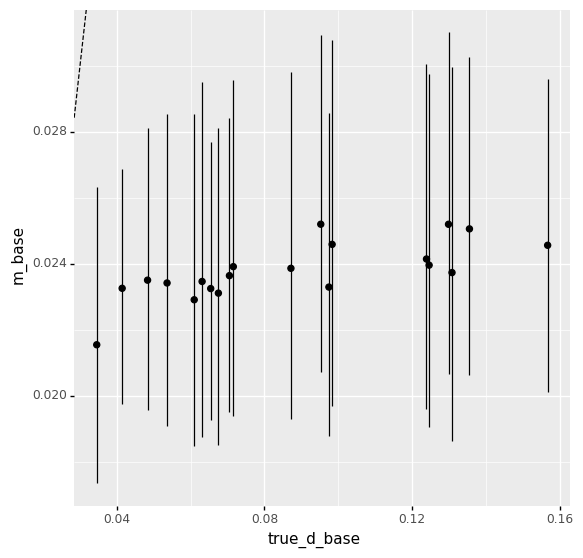

<ggplot: (2969790480879)>

In [61]:
from plotnine import * 

from scipy.special import expit

x = (
    df_posterior >>
    s.mutate(d_base = _.d_base_pop + _.d_base_r * _.d_base_sd, 
             d_prime = _.d_base + np.exp(_.d_delta_pop + _.d_delta_r *  _.d_delta_sd)
#              d_prime = _.d_base + np.exp(_.d_delta_pop + _.d_delta_r *  _.d_delta_sd)
         ) >> 
    s.group_by("ID") >>
    # s.summarize(
    #     m_base = _.d_subj.mean(),
    #     ll_base = _.d_subj.quantile(.025),
    #     ul_base = _.d_subj.quantile(.975)
    # )
    s.summarize(
        m_base = expit(_.d_base.mean())/3.,
        ll_base = expit(_.d_base.quantile(.025))/3.,
        ul_base = expit(_.d_base.quantile(.975))/3.,
        k_base = _.k.mean(),
        ll_k = _.k.quantile(.025),
        ul_k = _.k.quantile(.975)
    )
)


subj_params = (
    pd.DataFrame(params).reset_index() >> 
    s.rename(ID = _.index) >>
    s.mutate(
        true_d_base = _.beta / (_.N_base + 2*_.beta),
        true_d_prime = _.beta / (_.N_base + _.N_delta + 2*_.beta)
    )
)


(
    pd.merge(x, subj_params, on = "ID") >> 
#     s.mutate(ok = s.if_else(_.ll_base < _.true_d_base, s.if_else(_.ul_base > _.true_d_base, 1, 0), 0)) >>
    ggplot(aes(x="true_d_base", y = "m_base", ymin="ll_base", ymax="ul_base")) + 
    geom_pointrange() +
    geom_abline(intercept=0, slope=1, linetype="dashed") +
    # coord_flip() +
    theme(aspect_ratio=1)
)

Lots of uncertainy in the results for individual subject-level values with only 2 conditions. Plus, pretty clealry some bias to the estimates, biased to estiamte lower than actual values for d. Wonder if the population-level and sd estimates are right? Presumably they're also biased.

If we hypothetically icnrease to 10, then it looks unbiased and more confident. SVI approximation is overconfident but unbiased.

In [130]:
from scipy.special import expit
df_prior = prior_to_df_mlm(
    az_data, 
    ["N_prime_pop", "N_delta_pop", "N_prime_sd", "N_delta_sd", "beta_pop", "beta_sd"],
    ["N_prime_r", "N_delta_r", "beta_r"]
)

# x = (
#     df_prior >>
#     s.mutate(N_prime = 1 + np.exp(_.N_prime_pop + _.N_prime_r * _.N_prime_sd), 
#              N_base = _.N_prime + np.exp(_.N_delta_pop + _.N_delta_r *  _.N_delta_sd),
#              beta = expit(_.beta_pop + _.beta_r * _.beta_sd)*10
#          ) >> 
#     s.group_by("ID") >>
#     s.summarize(
#         m_prime = _.N_prime.mean(),
#         ll_prime = _.N_prime.quantile(.025),
#         ul_prime = _.N_prime.quantile(.975),
#         m_base =_.N_base.mean(),
#         ll_base = _.N_base.quantile(.025),
#         ul_base = _.N_base.quantile(.975),
        
#         m_beta =_.beta.mean(),
#         ll_beta = _.beta.quantile(.025),
#         ul_beta = _.beta.quantile(.975)
#     )
# )
x = (
    df_prior >>
    s.mutate(N_prime = 1 + np.exp(_.N_prime_pop + _.N_prime_r * _.N_prime_sd), 
             N_base = _.N_prime + np.exp(_.N_delta_pop + _.N_delta_r *  _.N_delta_sd),
             beta = expit(_.beta_pop + _.beta_r * _.beta_sd)*10
         ) >>
    s.filter(_.ID==0) 
)

p = softplus((x.N_prime_pop + x.N_prime_r * x.N_prime_sd).to_numpy())
len(p[p<10])/len(p)
# sns.distplot(p[p<100])
# (
#     s.mutate(N_prime = _.N_base, N_base = _.N_prime + _.N_delta) >>
# #     s.mutate(ok = s.if_else(_.ll_base < _.true_d_base, s.if_else(_.ul_base > _.true_d_base, 1, 0), 0)) >>
#     ggplot(aes(x="ID", y = "m_prime", ymin="ll_prime", ymax="ul_prime")) + 
#     geom_pointrange() +
#     geom_abline(intercept=0, slope=1, linetype="dashed") +
#     # coord_flip() +
#     theme(aspect_ratio=1)
# )

/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp


0.949

# PT+N simulations

should be working

In [180]:
d_bases = np.random.beta(1,3, n_participants)/2.
d_deltas = np.random.beta(1,3, n_participants)/2. * ((1-d_bases) - .5)


params_ptn = {
    "d_base": {k: d_bases[k] for k in range(0,n_participants)},
    "d_delta": {k: d_deltas[k] for k in range(0,n_participants)},
    "k":15
}

sim_data2 = make_sim_data_ptn_avg(n_participants, params_ptn)

X_data, y_data = make_model_data(sim_data2) # see data_helpers.py

In [181]:
mcmc_ptn = MCMC(NUTS(PTN_complex_mlm, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc_ptn.run(random.PRNGKey(0), X_data, y_data)

sample: 100%|██████████| 4000/4000 [01:16<00:00, 52.45it/s, 31 steps of size 1.40e-01. acc. prob=0.88] 


In [ ]:
# mcmc_ptn.print_summary()

3/24/21, 4:58 PM: Working! (earlier problem was simulation bug)

In [182]:
az_data_ptn = make_arviz_data(mcmc_ptn, PTN_complex_mlm, X_data)

In [183]:
df_posterior2 = posterior_to_df_mlm(
    az_data_ptn, 
    ["d_base_pop", "d_delta_pop", "d_base_sd", "d_delta_sd"],
    ["d_base_r", "d_delta_r", "d_subj", "d_prime_subj"]
)

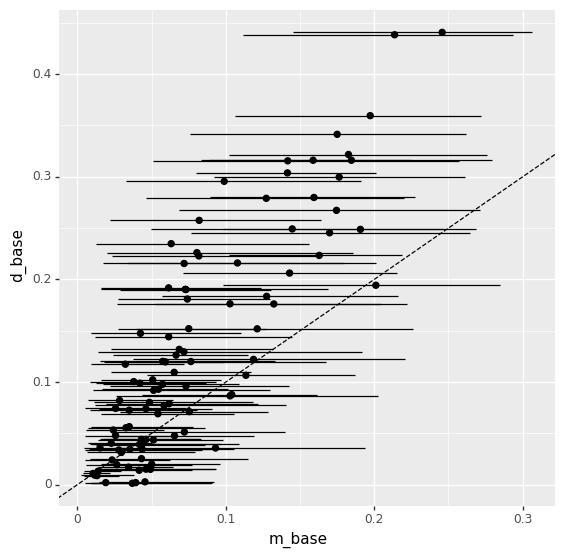

<ggplot: (8730819263591)>

In [184]:
x = (
    df_posterior2 >>
    s.mutate(d_base = _.d_base_pop + _.d_base_r * _.d_base_sd, 
             d_prime = _.d_base + np.exp(_.d_delta_pop + _.d_delta_r *  _.d_delta_sd)
         ) >> 
    s.group_by("ID") >>
    s.summarize(
        m_base = expit(_.d_base.mean())/3.,
        ll_base = expit(_.d_base.quantile(.025))/3.,
        ul_base = expit(_.d_base.quantile(.975))/3.,
        m_prime = expit(_.d_prime.mean())/3.,
        ll_prime = expit(_.d_prime.quantile(.025))/3.,
        ul_prime = expit(_.d_prime.quantile(.975))/3.
    )
)


subj_params = (
    pd.DataFrame(params_ptn).reset_index() >> 
    s.rename(ID = _.index) >>
    s.mutate(
        true_d_prime = _.d_base + _.d_delta,
    )
)


(
    pd.merge(x, subj_params, on = "ID") >> 
    ggplot(aes(x="d_base", y = "m_base", ymin="ll_base", ymax="ul_base")) + 
    geom_pointrange() +
    geom_abline(intercept=0, slope=1, linetype="dashed") +
    coord_flip() +
    theme(aspect_ratio=1)
)

## PROBLEM

8/9/22, 4:29 PM

Things aren't perfect but my concern was mostly overblown. It was indexing crap as always. Though things genuinely don't look that great in the PTN case. So will need to rework the simulation code probably to match the BS model.